<a href="https://colab.research.google.com/github/CD-GRUPO3/TA047R-1C2025-GRUPO03/blob/main/TA047R_TP1_GRUPO03_ENTREGA_EJ1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Grupo 3 - Ejercicio 1: *Análisis exploratorio de datos*
**Objetivo:** realizar un análisis completo del conjunto de datos, aplicar técnicas de exploración y de preprocesamiento para poder responder algunas preguntas que se planteen sobre los datos.

**Conjunto de datos:** [uso de Taxis Yellow Cab en USA](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page), particularmente los meses **Julio**, **Agosto** y **Septiembre**.

**Integrantes:**
- ARIAS, Rafaela Pilar. 112272. rparias@fi.uba.ar.
- BARCALA ROCA, Ramiro. 112478. rbarcala@fi.uba.ar.
- LEMA, Mora. 111831. molema@fi.uba.ar.
- IENCO, Lara Eliana. 111921. lienco@fi.uba.ar.

___

####Bibliografía:
Julca, J. E. (2025, febrero 22). Tipos de variables estadísticas: Cuantitativas y Cualitativas. Escuela de Investigación. Recuperado de: [Link](https://escueladeinvestigacion.com/2025/02/22/tipos-de-variables-estadisticas-cuantitativas-y-cualitativas/).

Sin Autor, (2022, junio 7). ¿Qué es una variable discreta? (ejemplos). Probabilidad y Estadística. [Link](https://www.probabilidadyestadistica.net/variable-discreta/).


#####Inicialiación del entorno

In [ ]:
#Importar las bibliotecas
import matplotlib.pyplot as plt   #Generación de gráficos
import numpy as np                #Operaciones matemáticas y estadísticas
import seaborn as sns             #Generación de gráficos
import pandas as pd               #Manipulación y análisis de datos
import pyarrow.parquet as pq      #Trabajar con archivos .parquet

#Configurar Pandas para que no use notación científica (CUALQUIER COSA ELIMINAR!!)
pd.set_option('display.float_format', '{:.6f}'.format)


In [ ]:
#Cargar los datos al Notebook
!gdown 1iju9XQghLYI4-XcDt1TVDE1O9ZwRyFVg
!gdown 1MukhnrymZ35FVsahXUs5I0cAeGJMoXgG
!gdown 1hEhbxXEC7Dc4iG0fKk2k1n8KM6emWxSg

Downloading...
From: https://drive.google.com/uc?id=1iju9XQghLYI4-XcDt1TVDE1O9ZwRyFVg
To: /content/yellow_tripdata_2024-07.parquet
100% 52.3M/52.3M [00:01<00:00, 45.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1MukhnrymZ35FVsahXUs5I0cAeGJMoXgG
To: /content/yellow_tripdata_2024-08.parquet
100% 51.1M/51.1M [00:01<00:00, 49.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1hEhbxXEC7Dc4iG0fKk2k1n8KM6emWxSg
To: /content/yellow_tripdata_2024-09.parquet
100% 61.2M/61.2M [00:01<00:00, 45.9MB/s]


In [ ]:
#Obtener cada DataFrame para utilizar Pandas
trips1 = pq.read_table('/content/yellow_tripdata_2024-07.parquet')
dataJulio = trips1.to_pandas()

trips2 = pq.read_table('/content/yellow_tripdata_2024-08.parquet')
dataAgosto = trips2.to_pandas()

trips3 = pq.read_table('/content/yellow_tripdata_2024-09.parquet')
dataSeptiembre = trips3.to_pandas()


#Unir los tres Dataframes (uno por mes)
data = pd.concat([dataJulio,dataAgosto,dataSeptiembre],axis=0, ignore_index=True)

#####Análisis de las variables

**Cuantitativas**
- **tpep_pickup_datetime:** La fecha y hora en que el taxímetro fue activado. **Tipo:** <u>cuantitativa **continua**</u>.
- **tpep_dropoff_datetime:** La fecha y hora en el que el taxímetro fue desactivado. **Tipo:** <u>cuantitativa **continua**</u>.
- **passenger_count:** El número de pasajeros en el vehículo, es un valor ingresado por el conductor. **Tipo:** <u>cuantitativa discreta</u>.
- **trip_distance:** La distancia del viaje transcurrida en millas reportada por el taxímetro. **Tipo:** <u>cuantitativa  **continua**</u>.
- **fare_amount:** La tarifa calculada por el taxímetro basada en el tiempo y la distancia. **Tipo:** <u>cuantitativa **continua**</u>.
- **extra:** Extras y recargos varios. Actualmente, esto solo incluye los recargos de USD 0.50 y USD 1 por hora punta y durante la noche. **Tipo:** <u>cuantitativa **discreta**</u>.
- **mta_tax:** Impuesto MTA de USD 0.50 que se activa automáticamente según la tarifa del taxímetro en uso. **Tipo:** <u>cuantitativa **continua**</u>.
- **tip_amount:** Monto de la propina. Este campo se completa automáticamente para las propinas pagadas con tarjeta de crédito. Las propinas en efectivo no están incluidas. **Tipo:** <u>cuantitativa **continua**</u>.
- **tolls_amount:** Monto total de todos los peajes pagados durante el viaje. **Tipo:** <u>cuantitativa **continua**</u>.
- **improvement_surcharge:** Recarga de mejora de USD 0.30 aplicado a los viajes al momento de iniciar el viaje (flag drop). **Tipo:** <u>cuantitativa **discreta**</u>.
- **total_amount:** El monto total cobrado a los pasajeros. No incluye las propinas en efectivo. **Tipo:** <u>cuantitativa **continua**</u>.
- **congestion_surcharge:** Monto total recaudado en el viaje por el recargo por congestión de NYS (Estado de Nueva York). **Tipo:** <u>cuantitativa **discreta**</u>.
- **Airport_fee:** USD 1.25 solo por la recogida en los aeropuertos de LaGuardia y John F. Kennedy. **Tipo:** <u>cuantitativa **discreta**</u>.

---

**Cualitativas**
- **VendorID:** Un código que indica el proveedor de TPEP (Taxi and Limousine Commission's Taxi Passenger Enhancement Program) que proporcionó el registro. *1 = Creative Mobile Technologies, LLC; 2 = VeriFone*. **Tipo:** <u>cualitativa **numérica nominal**</u>.
- **RatecodeID:** El código final de tarifa en vigor al final del viaje. *1 = Tarifa estándar; 2 = JFK; 3 = Newark; 4 = Nassau o Westchester; 5 = Tarifa negociada; 6 = Viaje en grupo*. **Tipo:** <u>cualitativa **numérica ordinal**</u>.
- **store_and_fwd_flag:** Un indicador que señala si el registro del viaje fue guardado en la memoria del vehículo antes de ser enviado al proveedor, también conocido como 'almacenar y reenviar', porque el vehículo no tenía conexión al servidor. *Y = viaje almacenado y reenviado; N = no es un viaje almacenado y reenviado*. **Tipo:** <u>cualitativa **texto nominal**</u>.
- **PULocationID:** Zona de taxi de la TLC (Comisión de Taxis y Limusinas) en la que se activó el taxímetro. **Tipo:** <u>cualitativa **numérica nominal**</u>.
- **DOLocationID:** Zona de taxi de la TLC en la que se desactivó el taxímetro. **Tipo:** <u>cualitativa **numérica nominal**</u>.
- **payment_type:** Un código numérico que indica cómo el pasajero pagó el viaje. *1 = Tarjeta de crédito; 2 = Efectivo; 3 = Sin cargo; 4 = Disputa; 5 = Desconocido; 6 = Viaje*. **Tipo:** <u>cualitativa **numérica nominal**</u>.






In [ ]:
lista_cuantitativas = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'Airport_fee']

#Diccionario para almacenar las medidas estadísticas de cada columna cuantitativa
dic_estadisticas_cuantitativo = {}  #FORMATO: {'nombre columna': Serie, 'nombre columna 2': Serie, ...}

#Obtener las medidas estadísticas de cada columna cuantitativa y guardarlas en el diccionario
for columna in lista_cuantitativas:
  moda = data[columna].mode()[0]
  medidas_estadisticas = data[columna].describe()  #Excluye los valores NaN, es una Serie
  medidas_estadisticas['moda'] = moda
  dic_estadisticas_cuantitativo[columna] = medidas_estadisticas
  print(medidas_estadisticas)

  print('\n')

  #PREGUNTAR: por las que tienen NaN





count                       9689116
mean     2024-08-18 09:55:55.561226
min             2008-12-31 23:03:46
25%      2024-07-25 13:58:48.750000
50%             2024-08-18 21:18:19
75%             2024-09-11 19:59:00
max             2024-10-01 21:24:53
moda            2024-07-17 22:04:00
Name: tpep_pickup_datetime, dtype: object


count                       9689116
mean     2024-08-18 10:13:43.063171
min             2009-01-01 00:13:25
25%             2024-07-25 14:18:55
50%             2024-08-18 21:34:52
75%             2024-09-11 20:14:00
max             2024-10-02 17:28:37
moda            2024-07-29 00:00:00
Name: tpep_dropoff_datetime, dtype: object


count   8667729.000000
mean          1.337451
std           0.811968
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           9.000000
moda          1.000000
Name: passenger_count, dtype: float64


count   9689116.000000
mean          5.296568
std         433.935453
min           0.000

In [ ]:
data['mta_tax'].unique()

array([ 0.5 , -0.5 ,  0.  ,  3.  ,  4.  ,  1.  , 10.5 ,  0.05,  5.75,
        2.9 ,  0.8 ,  3.25,  4.1 ])

In [ ]:
lista_cualitativas = ['VendorID','RatecodeID','store_and_fwd_flag','PULocationID','DOLocationID','payment_type']

#Diccionario para almacenar los valores únicos de cada columna cualitativa
dic_valores_unicos_cualitativo = {}  #FORMATO: {'nombre columna': Serie, 'nombre columna 2': Serie, ...}

#Obtener los valores únicos de cada columna cualitativa y guardarlas en el diccionario
for columna in lista_cualitativas:
  valores_unicos_cualitativos = data[columna].unique()
  print("La columna " + columna + " tiene los valores sin repetir" , data[columna].unique())
  dic_valores_unicos_cualitativo[columna] = valores_unicos_cualitativos

  print('\n')



La columna VendorID tiene los valores sin repetir [1 2 6]


La columna RatecodeID tiene los valores sin repetir [ 1.  2.  5.  4.  3. 99.  6. nan]


La columna store_and_fwd_flag tiene los valores sin repetir ['N' 'Y' None]


La columna PULocationID tiene los valores sin repetir [140 132 237 138 114 246  68 249 100 152 186 162 264 230 107  48 141 229
 236  90 262  41  79 234  70 164 158 239 144 142 113 263 148  50 231 161
 170 137 163  80 211 116 125 256 265  88 224 261 129  75 166 232 181 168
  43   4 233 255 112 238  45 244 226 146 193 124 143 196 235 243  37  87
  24 223   9  97  38 151 119  33  93 215   7 217  74 127 220  28  12  10
 179 219 157 260 216 209 165  42  82 130  83  14  65 145 188  52 177 135
  69 117 247  26  61  72  39  17  19  89  13  40  60 178  54  21 169  94
  25 160  35   1 225 205 134  98  51  86  73 197  95  64 258  92 259 123
 227  76  77 171  47  11 203  91 167 218 121 213  49 174  53  56  20 248
   3  71  32 155  62 108 241 102 139 222 159 202   6 195 154 212

In [20]:
for columna in lista_cualitativas:
  print("Frecuencias de la columna" , data[columna].value_counts(dropna=False))
  print('\n')
  print('-'*40)
  print('\n')

Frecuencias de la columna VendorID
2    7463904
1    2225103
6        109
Name: count, dtype: int64


----------------------------------------


Frecuencias de la columna RatecodeID
1.000000     8028335
NaN          1021387
2.000000      362700
99.000000     123978
5.000000       88011
3.000000       34015
4.000000       30673
6.000000          17
Name: count, dtype: int64


----------------------------------------


Frecuencias de la columna store_and_fwd_flag
N       8624127
None    1021387
Y         43602
Name: count, dtype: int64


----------------------------------------


Frecuencias de la columna PULocationID
132    553448
161    450424
237    414063
236    360038
162    335798
        ...  
199         7
44          5
204         5
5           2
99          1
Name: count, Length: 261, dtype: int64


----------------------------------------


Frecuencias de la columna DOLocationID
236    374531
237    372258
161    361373
230    320549
170    294202
        ...  
44         51
2

### **Variables a graficar:**

1. total_amount -> <u>**barra**</u>
2. passenger_count -> <u>**barra**</u>
3. trip_distance ->
4. Resta entre tpep_dropoff_datetime y tpep_pickup_datetime (? // tiempo de viaje -> <u>**lineplot**</u>
5. payment_type -> <u>**torta**</u>
6. PULocationID y DOLocationID
7. RatecodeID // tipo de tarifa -> <u>**torta**</u>
8. congestion_surcharge //new york impuesto (????????? -> <u>**barra**</u>
9. tpep_pickup_datetime hora pico de subida. -> <u>**densidad**</u>
10. tip_amount -> <u>**barra**</u>

### Relaciones:

1. Desde donde se suben hasta donde se bajan + la propina que dejan. -> <u>**regresión**</u>
2. Recaudacion total de TODOS los viajes respecto del dia. <u>**barra**</u>
3. Desde donde se suben mas a la hora pico. -> <u>**treemap**</u>
---
6. DOLocationID (bajada) + cantidad de pasajeros //lo q se bajan acá <u>**treemap**</u>
7. Duracion del viaje con respecto a la hora de subida. //ver cuanto tarda etc
8. Desde donde se suben los q hacen el viaje mas largo. <u>**treemap**</u> ?? ver la cantidad de esos.
9. Lugar de salida + cantidad de personas subiendose -> <u>**heatmap**</u> da pie a el (3)
10. Cantidad de viajes (todas las filas del dataframe) + dias semana (horizontal) + medios de pago. (puesto en discord) -> <u>**barra dos var**</u>


A debatir:

4. Precio total y medio de pago -> <u>**relación**</u>
5. Cantidad pasajeros y medio de pago -> <u>**relación**</u>

# GRAFICOS

In [ ]:
data.describe()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
count,9689116.000000,9689116,9689116,8667729.000000,9689116.000000,8667729.000000,9689116.000000,9689116.000000,9689116.000000,9689116.000000,9689116.000000,9689116.000000,9689116.000000,9689116.000000,9689116.000000,9689116.000000,8667729.000000,8667729.000000
mean,1.770395,2024-08-18 09:55:55.561226,2024-08-18 10:13:43.063171,1.337451,5.296568,2.502668,162.596838,162.023868,1.114232,19.767655,1.371863,0.477493,3.280805,0.593475,0.955656,28.312897,2.197805,0.165169
min,1.000000,2008-12-31 23:03:46,2009-01-01 00:13:25,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,-2261.200000,-7.500000,-0.500000,-93.420000,-116.700000,-1.000000,-2265.450000,-2.500000,-1.750000
25%,2.000000,2024-07-25 13:58:48.750000,2024-07-25 14:18:55,1.000000,1.030000,1.000000,132.000000,113.000000,1.000000,9.300000,0.000000,0.500000,0.000000,0.000000,1.000000,15.760000,2.500000,0.000000
50%,2.000000,2024-08-18 21:18:19,2024-08-18 21:34:52,1.000000,1.800000,1.000000,161.000000,162.000000,1.000000,14.200000,1.000000,0.500000,2.520000,0.000000,1.000000,21.000000,2.500000,0.000000
75%,2.000000,2024-09-11 19:59:00,2024-09-11 20:14:00,1.000000,3.540000,1.000000,231.000000,233.000000,1.000000,23.150000,2.500000,0.500000,4.200000,0.000000,1.000000,31.080000,2.500000,0.000000
max,6.000000,2024-10-01 21:24:53,2024-10-02 17:28:37,9.000000,330397.590000,99.000000,265.000000,265.000000,5.000000,2261.200000,16.190000,10.500000,523.950000,476.350000,1.000000,2265.450000,2.500000,1.750000
std,0.420846,NaN,NaN,0.811968,433.935453,11.634593,64.222091,69.762847,0.676254,20.473392,1.826801,0.136970,4.193002,2.306631,0.274009,25.263186,0.920417,0.532001


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9689116 entries, 0 to 9689115
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int32         
 8   DOLocationID           int32         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airport_fee           

In [ ]:
data.shape

(9689116, 19)

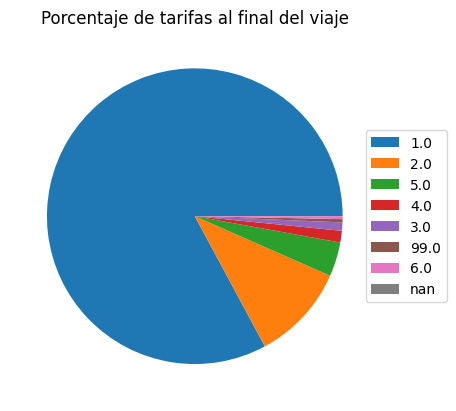

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
744,1,2024-07-01 00:37:21,2024-07-01 01:00:35,1.000000,9.900000,99.000000,N,226,130,1,35.500000,0.000000,0.500000,0.000000,0.000000,1.000000,37.000000,0.000000,0.000000
1010,1,2024-07-01 00:22:21,2024-07-01 00:22:21,0.000000,0.000000,99.000000,Y,235,264,3,178.940000,0.000000,0.000000,0.000000,0.000000,0.000000,178.940000,0.000000,0.000000
3613,1,2024-07-01 02:32:37,2024-07-01 04:38:06,1.000000,12.100000,99.000000,N,117,19,1,49.500000,0.000000,0.500000,0.000000,0.000000,0.000000,50.000000,0.000000,0.000000
4447,1,2024-07-01 03:09:11,2024-07-01 03:37:08,1.000000,0.000000,99.000000,N,219,75,1,52.500000,0.000000,0.500000,0.000000,6.940000,1.000000,60.940000,0.000000,0.000000
4669,1,2024-07-01 03:56:41,2024-07-01 04:37:52,1.000000,19.000000,99.000000,N,14,127,1,60.500000,0.000000,0.500000,0.000000,0.000000,0.000000,61.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9689111,2,2024-09-30 23:14:05,2024-09-30 23:47:48,NaN,14.880000,NaN,None,181,179,0,45.690000,0.000000,0.500000,0.000000,0.000000,1.000000,47.190000,NaN,NaN
9689112,1,2024-09-30 23:29:30,2024-10-01 00:41:40,NaN,0.000000,NaN,None,230,10,0,60.000000,2.000000,0.500000,0.000000,6.940000,1.000000,74.940000,NaN,NaN
9689113,1,2024-09-30 23:48:10,2024-09-30 23:57:09,NaN,1.100000,NaN,None,41,152,0,7.320000,0.000000,0.500000,0.000000,0.000000,1.000000,8.820000,NaN,NaN
9689114,2,2024-09-30 23:02:31,2024-09-30 23:29:30,NaN,9.250000,NaN,None,40,198,0,33.010000,0.000000,0.500000,0.000000,0.000000,1.000000,34.510000,NaN,NaN


In [ ]:
valores_unicos_ratecodeID = data['RatecodeID'].unique()
frecuencias_ratecodeID = data['RatecodeID'].value_counts(dropna=False)

#ACÁ SE VE QUE 99 ES UN VALOR ATÍPICO QUE DEBE SER FILTRADO! NO ES POSIBLE ESE VALOR.
plt.title('Porcentaje de tarifas al final del viaje')
plt.pie(frecuencias_ratecodeID)
plt.legend(valores_unicos_ratecodeID, loc='center right', bbox_to_anchor=(1.2, 0.5)) #loc sitúa la leyenda, bbox_to_anchor
                                                                                    #mueve más la leyenda porque tapaba el gráfico
plt.show()

#NaN ni figura en el gráfico, 99 tampoco --> veamos cuántas filas son afectadas.
data_filtrada = data[((data['RatecodeID'] == 99) | data['RatecodeID'].isna())]
data_filtrada


In [ ]:
print(data['payment_type'].unique())
#Tiene el 0, no debería ir porque NO EXISTE ese tipo de pago. Lo filtramos.

print('\n')

print(data['total_amount'].unique())
#No nos mostró todos los únicos pero ya vemos que hay números negativos. No debería haber negativos ni cero.

print(data.shape)
print('\n')

#Filtramos!!
data_filtrada = data[((data['payment_type'] != 0) & (data['total_amount'] > 0))]
print(data_filtrada.shape) #Si miramos la consola, disminuyó mucho.

plt.scatter(data_filtrada['payment_type'], data_filtrada['total_amount']) #tarda demasiado?????
plt.title('Relación entre métodos de pago y monto total')
plt.xlabel('Método de Pago')
plt.ylabel('Pago Total')
plt.show()


[1 2 3 4 5 0]


[ 24.1   75.75  16.32 ... -42.43 134.44   1.22]
(9689116, 19)


(8507973, 19)


KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7ee457c62480> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7ee457c53f60> (for post_execute):


KeyboardInterrupt: 

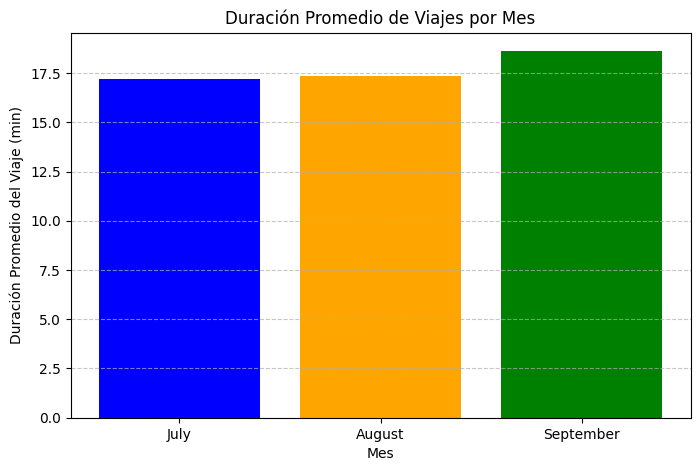

In [21]:
# Asegurar que las columnas sean de tipo datetime
data["fecha_recogida"] = pd.to_datetime(data["tpep_pickup_datetime"])
data["fecha_entrega"] = pd.to_datetime(data["tpep_dropoff_datetime"])

# Calcular la duración del viaje en minutos
data["duracion_viaje"] = (data["fecha_entrega"] - data["fecha_recogida"]).dt.total_seconds() / 60

# Extraer el mes de la fecha de recogida
data["mes"] = data["fecha_recogida"].dt.strftime("%B")  # "July", "August", "September"

# Agrupar por mes y calcular la duración promedio del viaje
duracion_promedio_mensual = data.groupby("mes")["duracion_viaje"].mean()

# Ordenar los meses en el orden correcto
orden_meses = ["July", "August", "September"]
duracion_promedio_mensual = duracion_promedio_mensual.reindex(orden_meses)

# Crear el gráfico de barras
plt.figure(figsize=(8, 5))
plt.bar(duracion_promedio_mensual.index, duracion_promedio_mensual, color=["blue", "orange", "green"])

# Etiquetas y título
plt.xlabel("Mes")
plt.ylabel("Duración Promedio del Viaje (min)")
plt.title("Duración Promedio de Viajes por Mes")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Mostrar el gráfico
plt.show()